<h1><center>Unsupervised Anomaly Sensor Detection - IMS Bearing NASA Acoustics and Vibration Database </center></h1>

## Introduction

In this project 4 unsupervised anomaly detection models from Pycaret will be used to detect anomalies in sensor bearing sensor signal. These models are: Decision Tree and Support Vector Machine. In addition, a customed LSTM model will be built using the PyTorch Framework to autoencode and decode the signal input. The data comprises three vibrational sensor readings from the NASA Acoustics and Vibration Database. The datasets contained text files with 1-second vibration signal snapshots (20,480 data points) recorded at 5 and 10 minute intervals at a sampling rate of 20 kHz. 

* Pycaret is a high-performance, open-source, low code library for ML modeling. It provides highly-efficient CPU/GPU implementations of ML models for  cluster analysis, classification,  time series and anomaly detection. Snap ML not only accelerates ML algorithms through system awareness, but also offers novel ML algorithms with best-in-class accuracy. Pycaret also automates ML workflows and aims to democratize ML. For more information, please visit [here] (https://pycaret.org/).

* PyTorch is a machine learning framework used for applications such as computer vision and natural language processing, originally developed by Meta AI and now part of the Linux Foundation umbrella. For more information, please visit [here] (https://pytorch.org/)

## Objectives


1.  Detect anomalies from sensor vibration signals unsupervised learning
2.  Build models that detect anomaly at earlies stages before sensor failure usin unsupervised traditional ML Algorithms 
3.  Buid an artificial neuralthat can be capable of detecting anomalies 
4. Compare the performance of the models and fine-tune hyperparameters for the best model(s).
4.  Visualize the data analysis results with plot types.

## Dataset 

The data comprises three vibrational sensor readings from the NASA Acoustics and Vibration Database. The datasets contained text files with 1-second vibration signal snapshots (20,480 data points) recorded at 5 and 10 minute intervals at a sampling rate of 20 kHz. 

The dataset is available on [kaggle](https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset).

## Installing required libraries

In [ ]:
%%capture
!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade

In [2]:
%%capture
!pip install mlflow

In [3]:
%%capture
!pip install umap-learn

In [4]:
%%capture
!pip install seaborn

In [5]:
# Comment out if not using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# comment out if not running in colab
%cd '/content/drive/MyDrive/anomaly'

/content/drive/MyDrive/anomaly


## Importing require libraries

In [1]:
# Import libraries
import os, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

## Import dependecies/supportig scripts

In [2]:
from concat_datasets import concat_raw_data, average_signal_dataset, dir_list
from plots import *

# Datasets processing

Data can be processed by changing the ```concat_data``` to True or running the script ```concat_datasets.py```. The ```txt``` dataset are concatenated and put together into one file per dataset test. In addition, data was transform (denoised) using the packag Scipy Fast Fourier Transforms (fft).

For the purpose of this work we will use the concatenated data with average reading for each of the 204080 sample points.

In [3]:
datasets = {'dataset_path1' : './ims_bearing/1st_test/1st_test',
           'dataset_path2' : './ims_bearing/2nd_test/2nd_test',
           'dataset_path3' : './ims_bearing/3rd_test/4th_test/txt'}

In [4]:
csv_data = os.path.join(os.getcwd(), 'csv_data')
os.makedirs(csv_data, exist_ok=True)


In [5]:
concat_data = False
def generate_datasets(datasets_dict=datasets, csv_path=csv_data):
    for i, (k, v) in enumerate(datasets_dict.items()):
        dataset_num = i + 1
        average_signal_dataset(v, dataset=dataset_num, csv_path=csv_path)
        concat_raw_data(v, csv_path, dataset=dataset_num, fourier_tr=True, detrends=False)

if concat_data:
    generate_datasets(datasets)


# Exploratory Data Analysis EDA

In [6]:
fft_dataset = [d for d in dir_list(csv_data) if 'fft' in d]
avg_dataset = [d for d in dir_list(csv_data) if not 'fft' in d]

In [7]:
def read_concat_data(path=None, fname=None):
    df = pd.read_csv(os.path.join(path, fname), index_col=0)
    df.index = pd.to_datetime(df.index)
    return df

In [8]:
avg_dataset

['avg_concat_dataset_1.csv',
 'avg_concat_dataset_2.csv',
 'avg_concat_dataset_3.csv']

In [9]:
avg_df1 = read_concat_data(csv_data, fname=avg_dataset[0])
print(f'Dataset size: {len(avg_df1)}')
avg_df1.head()

Dataset size: 2156


,b1_ch1,b1_ch2,b2_ch3,b2_ch4,b3_ch5,b3_ch6,b4_ch7,b4_ch8
2003-10-22 12:06:24,0.104144,0.100250,0.107151,0.102002,0.106148,0.108152,0.094804,0.099515
2003-10-22 12:09:13,0.103652,0.099853,0.108190,0.102922,0.106660,0.108453,0.095070,0.093585
2003-10-22 12:14:13,0.105036,0.101540,0.108548,0.104041,0.108741,0.109881,0.096157,0.098300
2003-10-22 12:19:13,0.104898,0.101570,0.108150,0.103379,0.108073,0.110006,0.096813,0.098600
2003-10-22 12:24:13,0.104776,0.102188,0.107943,0.102626,0.108453,0.109349,0.096359,0.098468


In [10]:
avg_df1.describe()

,b1_ch1,b1_ch2,b2_ch3,b2_ch4,b3_ch5,b3_ch6,b4_ch7,b4_ch8
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.127485,0.124183,0.125529,0.120615,0.132830,0.134874,0.124395,0.125285
std,0.006072,0.006244,0.005745,0.005540,0.014742,0.014387,0.014100,0.013660
min,0.103652,0.099853,0.106503,0.101036,0.106148,0.108152,0.048433,0.069658
25%,0.127832,0.124815,0.125422,0.120932,0.131230,0.133210,0.118644,0.119841
50%,0.128904,0.125841,0.126129,0.121639,0.132255,0.134239,0.120240,0.121462
75%,0.129828,0.126581,0.127190,0.122351,0.133679,0.135751,0.129112,0.131733
max,0.142146,0.132984,0.170624,0.162340,0.438412,0.364026,0.229181,0.221456


In [11]:
avg_df2 = read_concat_data(csv_data, fname=avg_dataset[1])
print(f'Dataset size: {len(avg_df2)}')
avg_df2.head()

Dataset size: 984


,b1_ch1,b2_ch2,b3_ch3,b4_ch4
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118


In [12]:
avg_df2.describe()

,b1_ch1,b2_ch2,b3_ch3,b4_ch4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060764,0.074232,0.076830,0.043949
50%,0.062005,0.075202,0.078197,0.044523
75%,0.083222,0.077462,0.080597,0.048110
max,0.453318,0.161011,0.151296,0.119042


In [13]:
avg_df3 = read_concat_data(csv_data, fname=avg_dataset[2])
print(f'Dataset size: {len(avg_df3)}')
avg_df3.head()

Dataset size: 6324


,b1_ch1,b2_ch2,b3_ch3,b4_ch4
2004-03-04 09:27:46,0.061629,0.075288,0.051990,0.043475
2004-03-04 09:32:46,0.060776,0.072208,0.052238,0.042038
2004-03-04 09:42:46,0.062192,0.072886,0.054810,0.041359
2004-03-04 09:52:46,0.062992,0.073434,0.054262,0.043128
2004-03-04 10:02:46,0.061945,0.073006,0.053243,0.042619


In [14]:
avg_df3.describe()

,b1_ch1,b2_ch2,b3_ch3,b4_ch4
count,6324.000000,6324.000000,6324.000000,6324.000000
mean,0.058445,0.064602,0.057390,0.044168
std,0.005061,0.009270,0.023149,0.011082
min,0.001533,0.002441,0.003663,0.001428
25%,0.056456,0.061596,0.052594,0.040506
50%,0.057657,0.062778,0.053941,0.043425
75%,0.059215,0.064786,0.055309,0.044282
max,0.122481,0.224447,0.543762,0.244888


In [15]:
# Release resources del the daset not used
del avg_df1
gc.collect()

0

## Visualise

* For this piece of work only the average readings datasets 2 and 3 will be used.


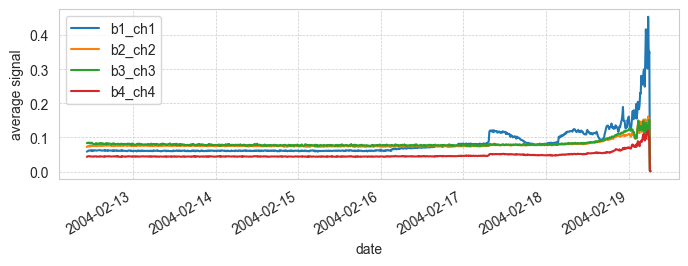

In [16]:
view_all(avg_df2, plot_name='avg_dataset2')

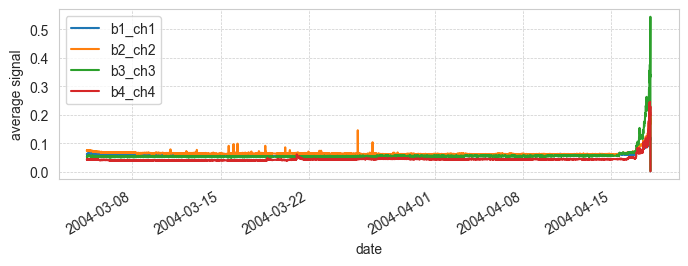

In [17]:
view_all(avg_df3, plot_name='avg_dataset3')

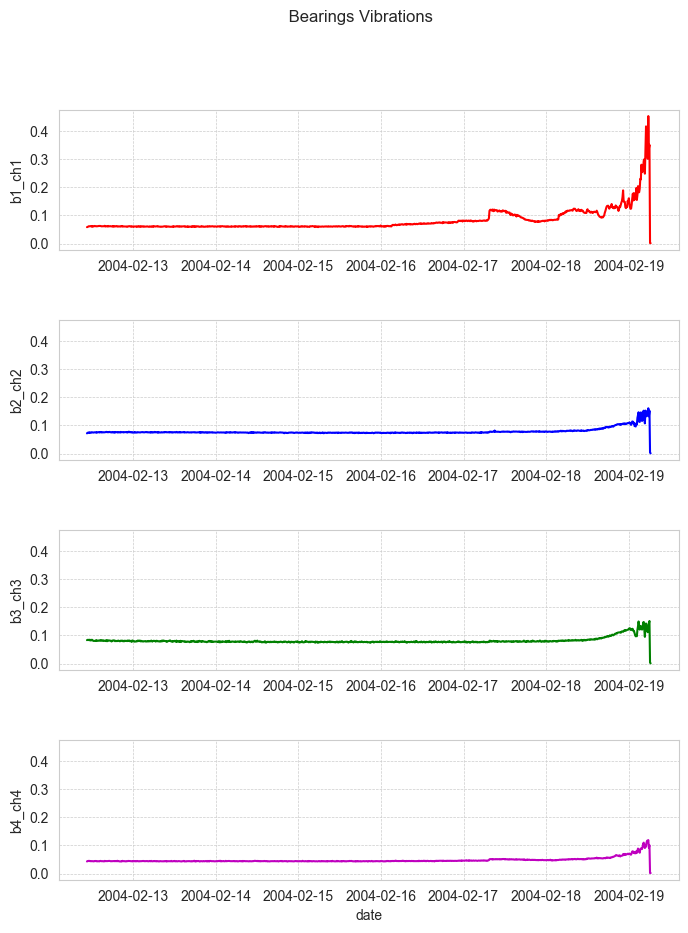

In [18]:
view_per_channel(avg_df2, plot_name='view_per_channel_avgdf2')

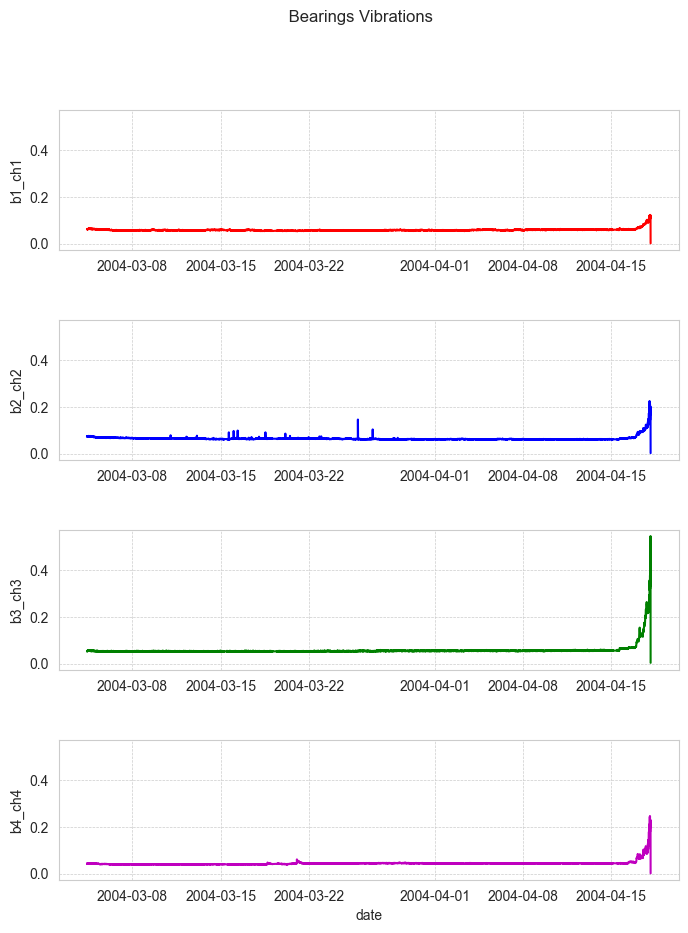

In [19]:
view_per_channel(avg_df3, plot_name='view_per_channel_avgdf3')

# Unsupervised Anomaly detection using PyCaret

The approach to unsupervised machine learning is:

* Dataset `avg_df2` will be used to train the model and to obtain the anomaly labels.
* The best models will be tested on unseen data , dataset `avg_df3`.
    
    

In [20]:
# Create directoty to save anomalies for model comparison
csv_files = os.path.join(os.getcwd(), 'csv_files')
os.makedirs(csv_files, exist_ok=True)

In [21]:
from pycaret.anomaly import *

In [22]:
# initiate setup
exp = setup(avg_df2, session_id=123, log_experiment=True, use_gpu=True)

In [23]:
# Show avaialable models
all_anomaly_models = models()
all_anomaly_models

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


## Model Selection

* Isolation Forest **iforest**
* Minimum Covariance Determinant **mcd**
* Clustering-Based Local outlier **cluster**
* One Class SVM **svm**
* Histogram-based Outlier Detection **histogram**
* K-Nearest Neighbors Detector **knn**

In [24]:
selected_models = ['cluster', 'histogram', 'iforest', 'knn', 'mcd', 'svm']

### Build train and predict fuction

In [25]:
def train_model(model_name=None):

    print(f'Assigning labels: {model_name} model')
    model = create_model(model_name)
    model_anomalies = assign_model(model)
    unique_labels = model_anomalies.Anomaly.unique()
    print(f'Unique labels: {unique_labels}')
    save_model(model, f'{model_name}_pipeline')
    return model_anomalies
    

In [26]:
def main(anomly_model_list=None):

    results_dict = {}
    anomaly_scores = {}
    for m in anomly_model_list:
        results = train_model(m)
        results_dict[m] = results.Anomaly
        anomaly_scores[m] = results.Anomaly_Score
        results_filter = results[results.Anomaly == 1]
        print(f'Anomalies detected by {m} model')
        print(f'Anomalous readings: {len(results_filter)}')
        print(' ')

    df_anomalies = pd.DataFrame.from_dict(results_dict)
    df_scores = pd.DataFrame.from_dict(anomaly_scores)
 
    return df_anomalies, df_scores

##  Run the training

In [27]:
anomaly_df, train_scores = main(selected_models)

Assigning labels: cluster model


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:32:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by cluster model
Anomalous readings: 50
 
Assigning labels: histogram model


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:32:52
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by histogram model
Anomalous readings: 50
 
Assigning labels: iforest model


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:32:53
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by iforest model
Anomalous readings: 50
 
Assigning labels: knn model


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:32:53
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by knn model
Anomalous readings: 50
 
Assigning labels: mcd model


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:32:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by mcd model
Anomalous readings: 50
 
Assigning labels: svm model


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:32:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by svm model
Anomalous readings: 50
 


In [28]:
# Save results for future comparison
anomaly_df.to_csv(os.path.join(csv_files, 'unsupervised_anomaly_pred.csv'))

## Visualize models results


All models detected anomalies only at the end of the test on avg_df2 dataset. It is not apparent
which model detectes earliest an anomalous signal.

These models detected anomalies mainly atthe begining of the test and at the end.

It can also be observed that anomalies were detected at the begining of the test in all models. KNN
model detected anomalies all along the test meanwhile SVM detected anomalies for the first half
of the test and at the end it.

In [29]:
print('Anomalies detected by model', anomaly_df.sum(axis=0), sep='\n')

Anomalies detected by model
cluster      50
histogram    50
iforest      50
knn          50
mcd          50
svm          50
dtype: int64


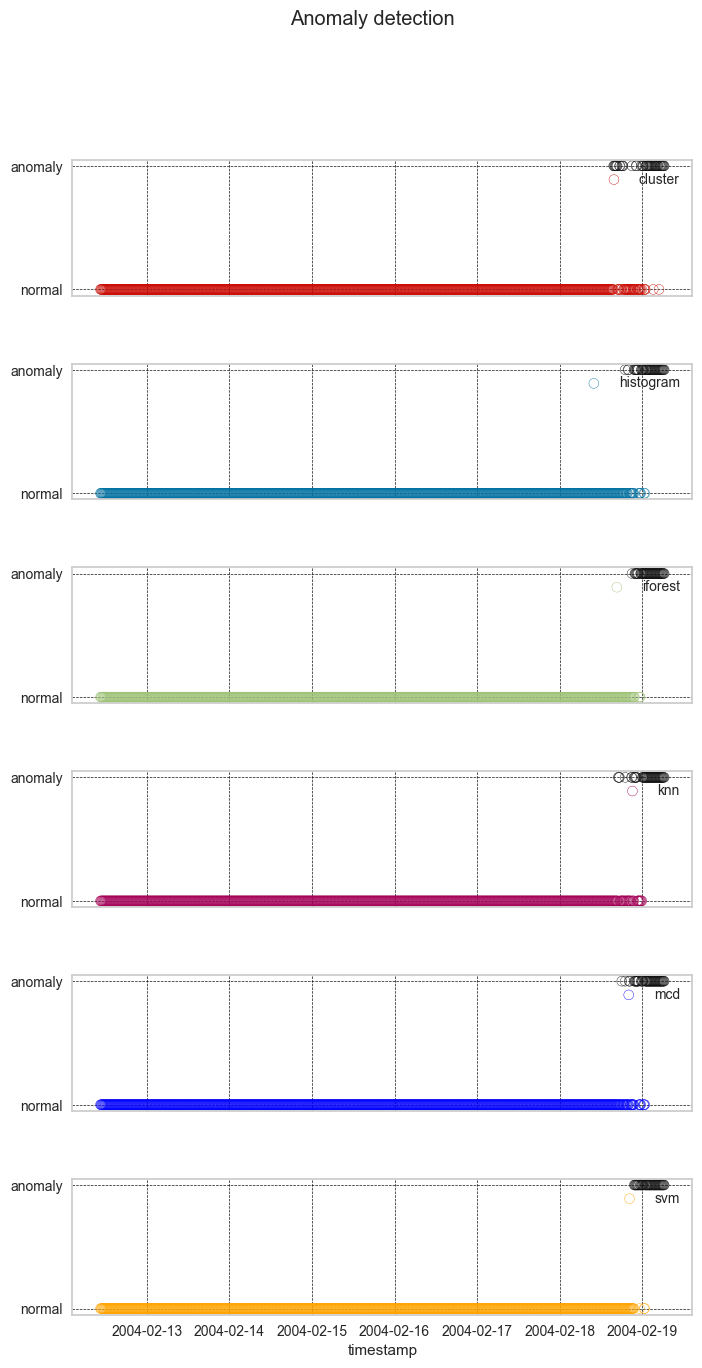

In [30]:
scatter_anomalies_plot(anomaly_df, 'anomalies')

In [31]:
train_anomalies = anomaly_df[(anomaly_df.index >= '2004-02-15') & (anomaly_df.sum(axis=1)>=1)]

In [32]:
print(f'The first anomaly that was detected from 2004-02-15 was on {train_anomalies.index[0]}')
print(f'Model: {train_anomalies.columns[np.where(train_anomalies.iloc[0].values)[0]][0]}')

The first anomaly that was detected from 2004-02-15 was on 2004-02-18 15:42:39
Model: cluster


In [33]:
train_anomalies.head()

,cluster,histogram,iforest,knn,mcd,svm
2004-02-18 15:42:39,1,0,0,0,0,0
2004-02-18 15:52:39,1,0,0,0,0,0
2004-02-18 16:02:39,1,0,0,0,0,0
2004-02-18 16:12:39,1,0,0,0,0,0
2004-02-18 16:22:39,1,0,0,0,0,0


In [34]:
print('Anomalies detected by model from 2004-04-15:', train_anomalies.sum(axis=0), sep='\n')

Anomalies detected by model from 2004-04-15:
cluster      50
histogram    50
iforest      50
knn          50
mcd          50
svm          50
dtype: int64


In [35]:
# Get time stamps at which at leats one models detected an anomaly on each timestamp
print(f'One or more models detected an anomaly in {len(train_anomalies)} timestamps')

One or more models detected an anomaly in 73 timestamps


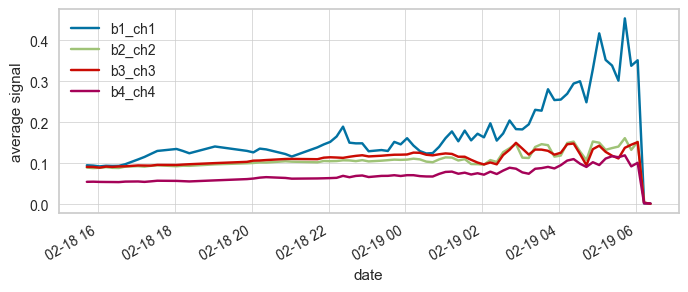

In [36]:
avg_df2.loc[train_anomalies.index].plot(xlabel='date', ylabel='average signal', figsize=(8,3))
plt.grid(True, lw=0.5)
plt.show()

In [37]:
common_detected_anomaly = train_anomalies[train_anomalies.sum(axis=1) == 6].index
print(f'All models detected anomalies in {len(common_detected_anomaly)} common timestamps')

All models detected anomalies in 35 common timestamps


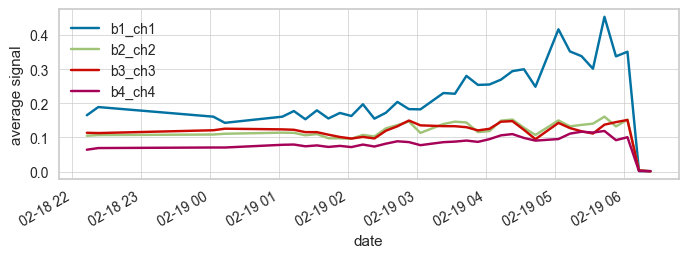

In [38]:
avg_df2.loc[common_detected_anomaly].plot(xlabel='date', ylabel='average signal', figsize=(8,2.5))
plt.grid(True, lw=0.5)
plt.show()

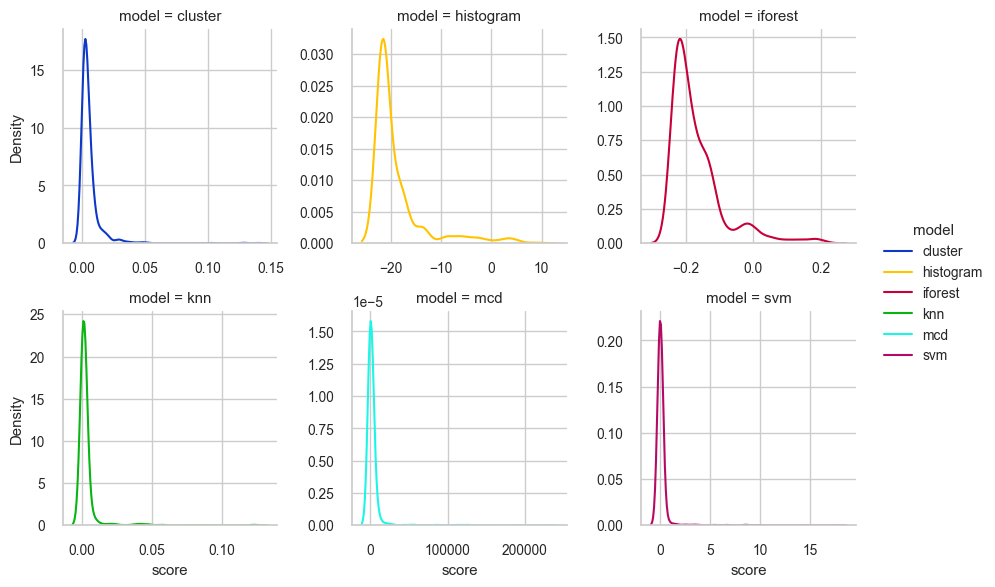

In [39]:
plot_scores_distribution(train_scores, plot_name='train_scores')

In [40]:
models_ = np.where(train_anomalies.iloc[0].values)[0]
models_ = [train_anomalies.columns[i] for i in models_]
print(f'The earliest that failure could have been detected by more than one model was: {train_anomalies.index[0]}')
print(f'Models: {models_}')

The earliest that failure could have been detected by more than one model was: 2004-02-18 15:42:39
Models: ['cluster']


In [41]:
print(f'The earliest that the failure could have been detected by all models was: {common_detected_anomaly[0]}')

The earliest that the failure could have been detected by all models was: 2004-02-18 22:12:39


In [42]:
print(f'Time for preventive maintenace before failure with at least one model detecting an anomaly:')
print(train_anomalies.index[-1] - train_anomalies.index[0])
print(' ')
print(f'Time for preventive maintenace before failure with all models detecting anomalies:')
print(train_anomalies.index[-1] - common_detected_anomaly[0])

Time for preventive maintenace before failure with at least one model detecting an anomaly:
0 days 14:40:00
 
Time for preventive maintenace before failure with all models detecting anomalies:
0 days 08:10:00



All models detected anomalies only at the end of the test on ```avg_df2``` dataset. It is
inconclusive which models are better at detecting anomalies at early stage withouth been a false
positive. For the training dataset the model that detected de anomaly the earliest was:
---

1.   Clustering-Based Local Outlier

---
Next all models will be tested on the unseen dataset ```avg_df3```.



In [43]:
# Release resources del the daset not used
del anomaly_df, train_anomalies, train_scores
gc.collect()

24294

## Prediction on unseen data

In [44]:
def predict_anomaly(unseen_data=None, anomly_model_list=None, thresh=0.10, plot_3d=False):

    best_models = dict()
    best_models_list = list()

    print(f'Unseen data size: {len(unseen_data)}')
    print('-'*58)
    for m in anomly_model_list:
        path_to_pipeline = os.path.join(os.getcwd(), f'{m}_pipeline')
        model = load_model(path_to_pipeline)
        predictions = predict_model(model, data=unseen_data)
        anomalies = predictions[predictions.Anomaly == 1]
        print(f'{m} model detected {len(anomalies)} anomalies in the unseen data')
        print('='*58)
        if len(anomalies) >= (thresh * len(predictions)):
            continue
        else:
            if plot_3d: 
                plot_model(model, plot='tsne')
            best_models[m] = predictions.Anomaly
            best_models[f'{m}_score'] = predictions.Anomaly_Score
            best_models_list.append(m)
    
    df_predictions = pd.DataFrame.from_dict(best_models)
            
    return  df_predictions, best_models_list


In [45]:
unseen_preds, models_list  = predict_anomaly(avg_df3, selected_models)

Unseen data size: 6324
----------------------------------------------------------
Transformation Pipeline and Model Successfully Loaded
cluster model detected 6133 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
histogram model detected 4843 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
iforest model detected 187 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
knn model detected 6304 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
mcd model detected 78 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
svm model detected 95 anomalies in the unseen data


In [46]:
unseen_preds[models_list].to_csv(os.path.join(csv_files, 'unsupervised_test_anomalys.csv'))

In [47]:
unseen_preds[models_list].sum(axis=0)

iforest    187
mcd         78
svm         95
dtype: int64

In [48]:
test_anomalies = unseen_preds[models_list][unseen_preds[models_list].sum(axis=1) >=1]

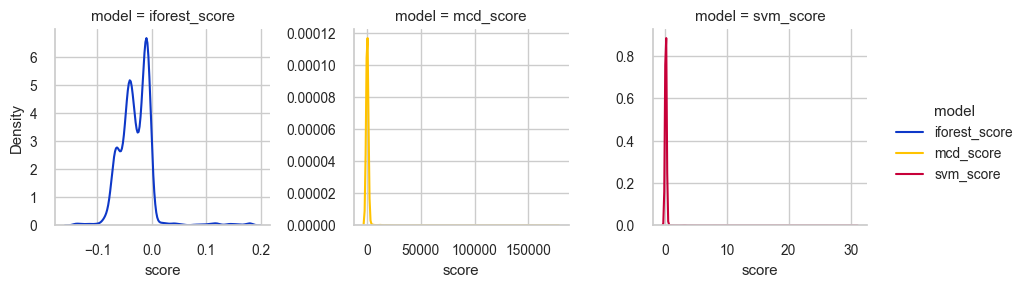

In [49]:
test_scores = unseen_preds.drop(columns=models_list)
plot_scores_distribution(test_scores, size=(3, 2), plot_name='test_scores')

In [50]:
test_anomalies[(test_anomalies.index > '2004-04-15') & (test_anomalies.sum(axis=1)>=1)][0:5]

,iforest,mcd,svm
2004-04-17 01:12:55,1,0,0
2004-04-17 01:22:55,1,0,0
2004-04-17 01:32:55,1,0,0
2004-04-17 01:42:55,1,0,0
2004-04-17 01:52:55,1,0,0


In [51]:
earliest_tail = test_anomalies[(test_anomalies.sum(axis=1)>1) & (test_anomalies.index 
                                                                 > '2004-04-15')]

In [52]:
print(f'The earliest that the failure could have been detected was on :')
print(f"{test_anomalies[(test_anomalies.index > '2004-04-15')].index[0]}")
print(f'Model: {test_anomalies.columns[np.where(test_anomalies.iloc[0].values)[0]][0]}')

The earliest that the failure could have been detected was on :
2004-04-17 01:12:55
Model: iforest


In [53]:
print(f'The earliest that failure could have been detected by more than one model was: {earliest_tail.index[0]}')
print(f'{earliest_tail.iloc[0]}')

The earliest that failure could have been detected by more than one model was: 2004-04-17 05:22:55
iforest    1
mcd        0
svm        1
Name: 2004-04-17 05:22:55, dtype: int64


In [54]:
print('The earliest the three models could have detected the failure was')
print(f'{earliest_tail[earliest_tail.sum(axis=1) ==3].index[0]}')

The earliest the three models could have detected the failure was
2004-04-17 12:22:55


In [55]:
time_left = earliest_tail.index[-1] - earliest_tail.index[0]
print(f'Time to prevent failure: {time_left}')

Time to prevent failure: 0 days 21:20:00


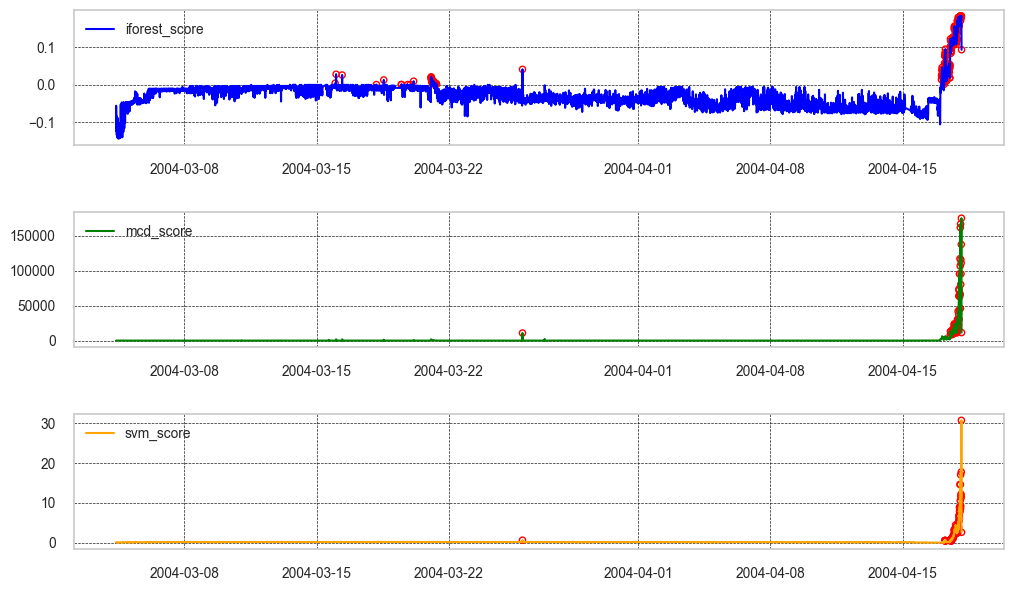

In [56]:
plot_predicted_anomalies(test_scores, test_anomalies, plot_name='test_anomaly_prediction')

The best performances on the test dataset ```avg_df3``` were:

1.   iforest
2.   mcd
3.   svm



In [57]:
del unseen_preds, 
del test_anomalies
del test_scores
del earliest_tail
gc.collect()


56424

# Multiseries Anomaly Prediction with Artificial Neural Networks -BiLSTM

In [58]:
from sklearn.preprocessing import MinMaxScaler
from collections import namedtuple
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data

Approach to deep learning:

* Built configurable Encoder - Decoder Model using PyTorch
* Process data - scaling
* Built training, evaluation and prediction functions
* Build the data loaders for batch processing, seelect, optimizers loss function and hyperparameters
* Experimental setup
* Train and validate model on avg_df3 dataset
* Visualise training metrics
* Test model on avg_df2
* Visualise tests metrics
* Optimize model

## Build configurable encoder-Decoder model - BiLSTM

In [59]:
class AnomalyLSTM(nn.Module):

    def __init__(self, input_size, hidden_dim=24, num_layers=2):
        super(AnomalyLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
          input_size=self.input_size,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          bidirectional=True,
          batch_first=True)

        self.linear1 = nn.Linear(self.hidden_dim * 2, 12)
        self.linear2 = nn.Linear(12, self.input_size)
        self.dropout = nn.Dropout1d(0.1)

    def forward(self, x):

        lstm_out, hidden = self.lstm(x.view(-1, 1, self.input_size))
        out = torch.cat((hidden[0][-2, :, :], hidden[0][-1, :, :]), dim=1)
        out = F.relu(self.linear1(out))
        out = self.dropout(out)
        out = self.linear2(out)

        return out


## Process data

In [60]:
def process_dataset(df):

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values)
    data_tensors = torch.tensor(np.array(scaled_data), dtype=torch.float32)
    print(data_tensors.shape)

    return data_tensors

In [61]:
train_idx = round(len(avg_df3) * 0.95)

In [62]:
train_data = process_dataset(avg_df3.iloc[:train_idx])
val_data = process_dataset(avg_df3.iloc[train_idx:, : ])
test_data = process_dataset(avg_df2)

torch.Size([6008, 4])
torch.Size([316, 4])
torch.Size([984, 4])


## Build training, evaluation and  prediction functions

In [63]:
def train_one_epoch(**kwargs):
    """
    :param kwargs: hyperparameters dictionary
    :return:training los for one epoch
    """
        
    total_loss = 0
    model = kwargs['model'].to(kwargs['device'])
    model.train()

    for true_seq in kwargs['train_loader']:
        kwargs['optimizer'].zero_grad()
        true_seq = true_seq.to(device)
        pred_seq = model(true_seq)
        loss = kwargs['loss_fn'](pred_seq, true_seq)
        loss.backward()
        kwargs['optimizer'].step()
        total_loss += loss.item()

    return total_loss / len(kwargs['train_loader'])

In [64]:
def evaluate(**kwargs):
    """
    :param kwargs: a hyperparameters dictionary
    :return: evalution loss
    """

    total_loss = 0
    model = kwargs['model'].eval()
    with torch.no_grad():
        for true_seq in kwargs['eval_loader']:
            true_seq = true_seq.to(kwargs['device'])
            pred_seq = model(true_seq)
            loss = kwargs['loss_fn'](pred_seq, true_seq)     
            total_loss += loss.item()

    return total_loss / len(kwargs['eval_loader'])

In [65]:
def time_minutes(s):
    """
    :param s:  time in seconds
    :return: time in hh:mm:ss format
    """
    return time.strftime('%H:%M:%S', time.gmtime(s))

In [66]:
def train_lstm(**kwargs):
    """
    :param kwargs: a hyperparameters dictionary
    :return: namedtuple - statistics
    """
    Stats = namedtuple('Stats', ['train_loss', 'val_loss'])
    
    train_loss_log = np.zeros(kwargs['epochs'])
    val_loss_log = np.zeros(kwargs['epochs'])

    best_loss = np.inf

    epoch_start_time = time.time()
    print('........Training Starting.......')
    for epoch in tqdm(range(kwargs['epochs'])):
        train_loss = train_one_epoch(**kwargs)
        val_loss = evaluate(**kwargs)
        train_loss_log[epoch] = train_loss
        val_loss_log[epoch] = val_loss

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({'epoch': epoch + 1, 'model': kwargs['model'].state_dict(),
                    'optim': kwargs['optimizer'].state_dict()},
                    os.path.join(kwargs['params'], f"best_exp_{kwargs['exp']}.pt"))
            
        if (epoch + 1) % 5 ==0:
            
            print(' ')
            print('Epoch %d: | train loss: %.4f  | val loss %.4f' % (epoch + 1,
                                                                     train_loss, val_loss))
    total_time = time.time() - epoch_start_time
    print('Training time {}'.format(time_minutes(total_time)))
    stats = Stats(train_loss=train_loss_log, val_loss=val_loss_log)

    return stats

In [67]:
def predict(model, data_loader, loss_fn=None):

    preds_log, loss_log = [], []
    with torch.no_grad():
        model = model.eval()
        for seqs_batch in data_loader:
            for seq in seqs_batch:
                seq = seq.to(device)
                seq_pred = model(seq)
                loss = loss_fn(seq_pred, seq)
                preds_log.append(seq_pred.cpu().numpy().flatten())
                loss_log.append(loss.item())
    return preds_log, loss_log

## Experimental setup

In [68]:
exps =[i for i in range(1, 5)]
network = ['bilstm'] * 4
exp_optim = sorted(['adam', 'adamw'] * 2)
exp_loss = ['mae_loss', 'huber_loss'] * 2

exp_setup = pd.DataFrame({'Exp':exps, 'Model':network, 'Loss': exp_loss, 'Optim':exp_optim },
                         index=exps)
exp_setup.set_index('Exp', drop=True, inplace=True)

In [69]:
exp_setup

,Model,Loss,Optim
Exp,,,
1,bilstm,mae_loss,adam
2,bilstm,huber_loss,adam
3,bilstm,mae_loss,adamw
4,bilstm,huber_loss,adamw


## Hyperparameter selection and training

In [72]:
batch = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bilstm_model = AnomalyLSTM(input_size=4, hidden_dim=32, num_layers=1).to(device)
print(bilstm_model)
learning_rate = 0.0002
mae_loss = nn.L1Loss('mean')
huber_loss = nn.SmoothL1Loss('mean')
adam_optim = optim.Adam(bilstm_model.parameters(), lr=learning_rate)
adamw_optim = optim.AdamW(bilstm_model.parameters(), lr=learning_rate)
train_loader = data.DataLoader(train_data, shuffle=False, batch_size=batch)
val_loader = data.DataLoader(val_data, shuffle=False, batch_size=batch)
test_loader = data.DataLoader(test_data, shuffle=False, batch_size=batch)


AnomalyLSTM(
  (lstm): LSTM(4, 32, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=64, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=4, bias=True)
  (dropout): Dropout1d(p=0.1, inplace=False)
)


In [73]:
exp = 4

weights_dir = os.path.join(os.getcwd(), 'params')
os.makedirs(weights_dir, exist_ok=True)

config = {'exp': exp, 'epochs': 200,  'model':bilstm_model, 'loss_fn':mae_loss, 
          'optimizer': adamw_optim, 'train_loader': train_loader,'eval_loader': val_loader, 
          'device': device, 'params' : weights_dir}
if exp in [1, 2]:
    config['optimizer'] = adam_optim
if exp in [2, 4]:
    config['loss_fn'] = huber_loss
elif exp > 4:    
    assert exp > 4, 'Experiment not in the experimental setup'

print(f'Running experiment {exp}', f'{exp_setup.loc[exp]}', sep='\n')
training_metrics = train_lstm(**config)


Running experiment 4
Model        bilstm
Loss     huber_loss
Optim         adamw
Name: 4, dtype: object
........Training Starting.......


  2%|▎         | 5/200 [00:02<01:30,  2.16it/s]

 
Epoch 5: | train loss: 0.0067  | val loss 0.0277


  5%|▌         | 10/200 [00:04<01:14,  2.55it/s]

 
Epoch 10: | train loss: 0.0055  | val loss 0.0251


  8%|▊         | 15/200 [00:06<01:09,  2.67it/s]

 
Epoch 15: | train loss: 0.0040  | val loss 0.0225


 10%|█         | 20/200 [00:08<01:14,  2.41it/s]

 
Epoch 20: | train loss: 0.0030  | val loss 0.0220


 12%|█▎        | 25/200 [00:10<01:17,  2.26it/s]

 
Epoch 25: | train loss: 0.0021  | val loss 0.0216


 15%|█▌        | 30/200 [00:12<01:10,  2.40it/s]

 
Epoch 30: | train loss: 0.0015  | val loss 0.0205


 18%|█▊        | 35/200 [00:14<01:05,  2.51it/s]

 
Epoch 35: | train loss: 0.0013  | val loss 0.0194


 20%|██        | 40/200 [00:16<01:05,  2.45it/s]

 
Epoch 40: | train loss: 0.0012  | val loss 0.0181


 22%|██▎       | 45/200 [00:18<01:04,  2.40it/s]

 
Epoch 45: | train loss: 0.0011  | val loss 0.0161


 25%|██▌       | 50/200 [00:20<01:00,  2.48it/s]

 
Epoch 50: | train loss: 0.0009  | val loss 0.0138


 28%|██▊       | 55/200 [00:22<00:59,  2.45it/s]

 
Epoch 55: | train loss: 0.0008  | val loss 0.0141


 30%|███       | 60/200 [00:24<00:56,  2.49it/s]

 
Epoch 60: | train loss: 0.0007  | val loss 0.0148


 32%|███▎      | 65/200 [00:26<00:55,  2.45it/s]

 
Epoch 65: | train loss: 0.0007  | val loss 0.0152


 35%|███▌      | 70/200 [00:28<00:52,  2.48it/s]

 
Epoch 70: | train loss: 0.0007  | val loss 0.0152


 38%|███▊      | 75/200 [00:30<00:50,  2.45it/s]

 
Epoch 75: | train loss: 0.0007  | val loss 0.0149


 40%|████      | 80/200 [00:32<00:48,  2.45it/s]

 
Epoch 80: | train loss: 0.0006  | val loss 0.0143


 42%|████▎     | 85/200 [00:34<00:46,  2.45it/s]

 
Epoch 85: | train loss: 0.0007  | val loss 0.0133


 45%|████▌     | 90/200 [00:36<00:45,  2.40it/s]

 
Epoch 90: | train loss: 0.0007  | val loss 0.0118


 48%|████▊     | 95/200 [00:38<00:45,  2.31it/s]

 
Epoch 95: | train loss: 0.0007  | val loss 0.0095


 50%|█████     | 100/200 [00:40<00:42,  2.37it/s]

 
Epoch 100: | train loss: 0.0006  | val loss 0.0072


 52%|█████▎    | 105/200 [00:42<00:40,  2.37it/s]

 
Epoch 105: | train loss: 0.0006  | val loss 0.0048


 55%|█████▌    | 110/200 [00:44<00:38,  2.31it/s]

 
Epoch 110: | train loss: 0.0006  | val loss 0.0029


 57%|█████▊    | 115/200 [00:47<00:44,  1.92it/s]

 
Epoch 115: | train loss: 0.0006  | val loss 0.0018


 60%|██████    | 120/200 [00:49<00:38,  2.05it/s]

 
Epoch 120: | train loss: 0.0006  | val loss 0.0012


 62%|██████▎   | 125/200 [00:52<00:33,  2.22it/s]

 
Epoch 125: | train loss: 0.0006  | val loss 0.0009


 65%|██████▌   | 130/200 [00:54<00:32,  2.18it/s]

 
Epoch 130: | train loss: 0.0005  | val loss 0.0008


 68%|██████▊   | 135/200 [00:56<00:31,  2.09it/s]

 
Epoch 135: | train loss: 0.0006  | val loss 0.0008


 70%|███████   | 140/200 [00:58<00:26,  2.23it/s]

 
Epoch 140: | train loss: 0.0005  | val loss 0.0007


 72%|███████▎  | 145/200 [01:01<00:24,  2.29it/s]

 
Epoch 145: | train loss: 0.0006  | val loss 0.0007


 75%|███████▌  | 150/200 [01:03<00:21,  2.34it/s]

 
Epoch 150: | train loss: 0.0006  | val loss 0.0007


 78%|███████▊  | 155/200 [01:05<00:19,  2.30it/s]

 
Epoch 155: | train loss: 0.0006  | val loss 0.0007


 80%|████████  | 160/200 [01:07<00:17,  2.28it/s]

 
Epoch 160: | train loss: 0.0006  | val loss 0.0007


 82%|████████▎ | 165/200 [01:10<00:17,  2.03it/s]

 
Epoch 165: | train loss: 0.0006  | val loss 0.0006


 85%|████████▌ | 170/200 [01:12<00:13,  2.31it/s]

 
Epoch 170: | train loss: 0.0006  | val loss 0.0006


 88%|████████▊ | 175/200 [01:14<00:10,  2.38it/s]

 
Epoch 175: | train loss: 0.0006  | val loss 0.0007


 90%|█████████ | 180/200 [01:16<00:08,  2.37it/s]

 
Epoch 180: | train loss: 0.0005  | val loss 0.0007


 92%|█████████▎| 185/200 [01:18<00:06,  2.38it/s]

 
Epoch 185: | train loss: 0.0006  | val loss 0.0007


 95%|█████████▌| 190/200 [01:20<00:04,  2.38it/s]

 
Epoch 190: | train loss: 0.0005  | val loss 0.0007


 98%|█████████▊| 195/200 [01:22<00:02,  2.37it/s]

 
Epoch 195: | train loss: 0.0006  | val loss 0.0007


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]

 
Epoch 200: | train loss: 0.0005  | val loss 0.0007
Training time 00:01:24


## Metrics visualization

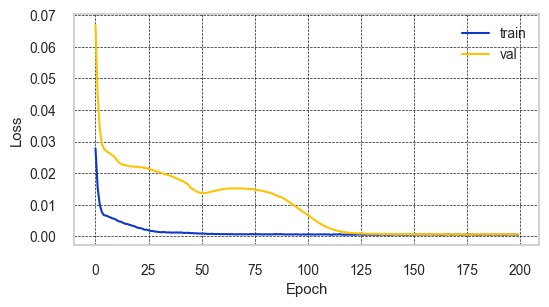

In [74]:
plot_loss(training_metrics, f'bilstm_exp{exp}', figs_dir=plots_dir)

In [75]:
del training_metrics
gc.collect()

4571

In [98]:
best_params = torch.load(os.path.join(weights_dir, f'best_exp_{exp}.pt'))
bilstm_model.load_state_dict(best_params['model'], strict=False)
concat_data = torch.cat([train_data, val_data])
concat_dataloader = data.DataLoader(concat_data, shuffle=False, batch_size=batch)
train_preds, train_losses = predict(bilstm_model, concat_dataloader, config['loss_fn'])                                     

## Scores and threshold Visuualization

In [99]:
import seaborn as sns

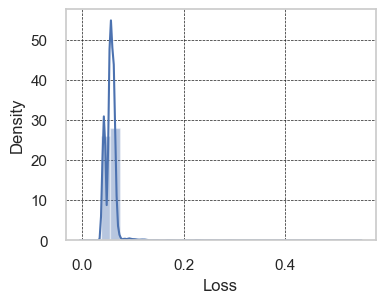

In [100]:
sns.set(rc={'figure.figsize': (4, 3)})
sns.set_style('whitegrid')
sns.distplot(avg_df3.values, bins=30, kde=True)
plt.grid(color ='k', ls= '--', lw=0.5)
plt.xlabel('Loss')
plt.show()


In [101]:
np.quantile(avg_df3.values, [0.75, 0.8, 0.85, 0.90, 0.95, 0.98, 0.99])

array([0.06123102, 0.06192544, 0.06287408, 0.06436785, 0.06681847,
       0.08007517, 0.10683016])

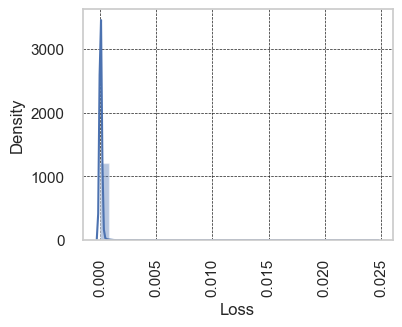

In [102]:
sns.set(rc={'figure.figsize': (4, 3)})
sns.set_style('whitegrid')
sns.distplot(train_losses, bins=30, kde=True)
plt.grid(color ='k', ls= '--', lw=0.5)
plt.xlabel('Loss')
plt.xticks(rotation=90)
save_plot(plots_dir, plot_name=f'train_dist_exp{exp}')
plt.show()


In [103]:
np.percentile(train_losses, 99)

0.0005046327575109885

In [104]:
threshold = 0.000505
print(threshold)

0.000505


In [105]:
train_scores = pd.DataFrame(index=avg_df3.index)
loss_column = 'huber_loss' if config['loss_fn'] == huber_loss else 'mae_loss'
train_scores[loss_column] = train_losses
train_scores['Anomaly'] =  [0 if l < threshold else 1 for l in train_losses]
train_scores.to_csv(os.path.join(csv_files, f'bilstm_train_exp{exp}.csv'))

In [106]:
threshold_ = np.array([threshold]*len(train_scores))

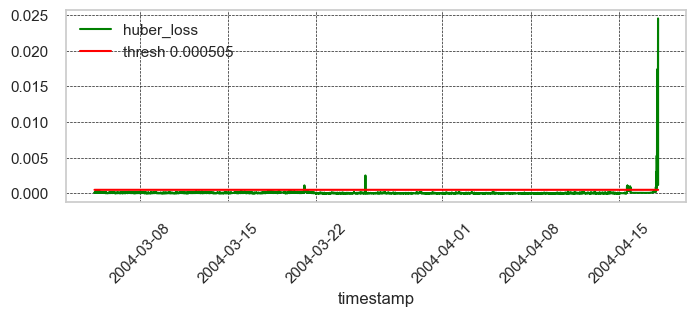

In [107]:
plot_anomaly_threshold(train_scores, thresh=threshold_, plot_name=f'bilstm_thresh_exp{exp}')

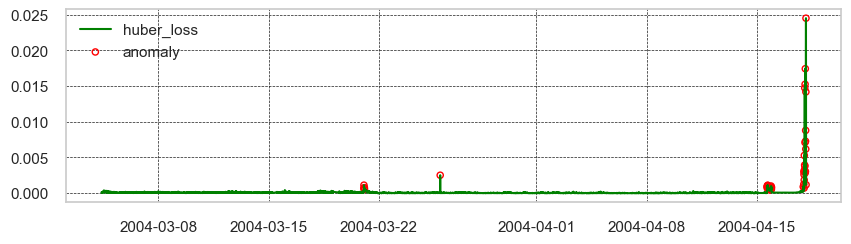

In [108]:
bilstm_predicted_anomalies(train_scores, size=(10, 2.5), plot_name=f'bilstm_val_pred_anom_exp{exp}')

In [109]:
preds_array = np.array(train_preds)

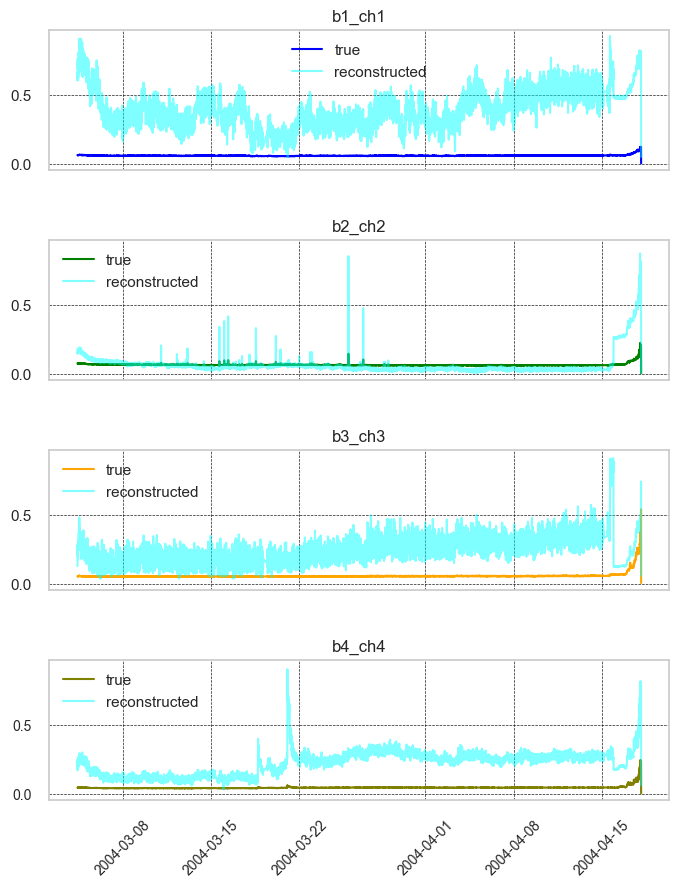

In [110]:
plot_reconstruction(avg_df3, preds_array, plot_name=f'bilstm_rec_exp{exp}')

In [111]:
del train_preds, 
del train_losses
del train_scores
gc.collect()

40257

## Predict on unseen data

In [112]:
bilstm_model.load_state_dict(best_params['model'], strict=False)

<All keys matched successfully>

In [113]:
test_preds, test_losses = predict(bilstm_model, test_loader, config['loss_fn'])

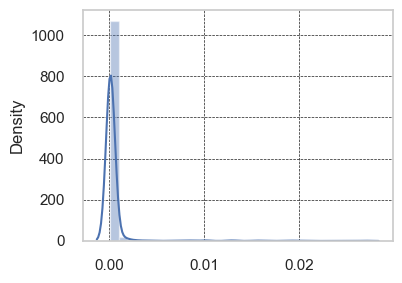

In [114]:
plt.figsize = (5,5)
sns.set_style('whitegrid', {"grid.color": 'k', 'grid.linestyle': '--'})
sns.distplot(test_losses, bins=30, kde=True)
plt.grid(lw=0.5, c='k')
plt.show()

In [115]:
test_scores = pd.DataFrame(index=avg_df2.index)
test_scores[loss_column] = test_losses
test_scores['Anomaly'] =  [0 if l < threshold else 1 for l in test_losses]
test_scores.to_csv(os.path.join(csv_files, f'bilstm_test_exp{exp}.csv'))

In [116]:
threshold_ = np.array([threshold]*len(test_scores))

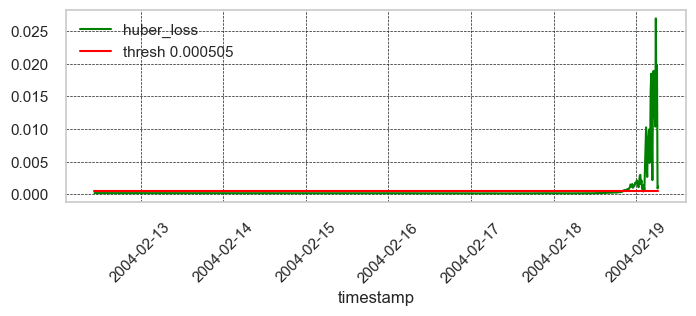

In [117]:
plot_anomaly_threshold(test_scores, thresh=threshold_, plot_name=f'test_thres_bilstm_exp_{exp}')

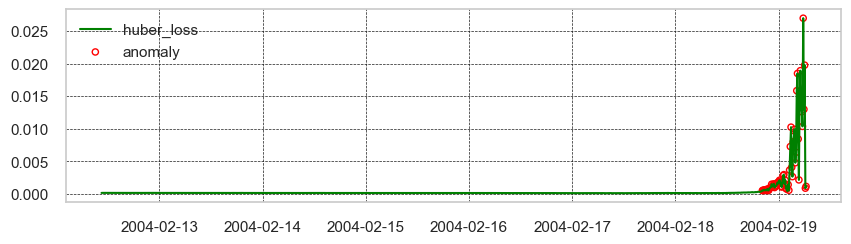

In [118]:
# loss scores with anomalies
bilstm_predicted_anomalies(test_scores,  size=(10, 2.5),
                         plot_name=f'test_bilstm_anom_exp{exp}')

In [119]:
test_preds_array = np.array(test_preds)

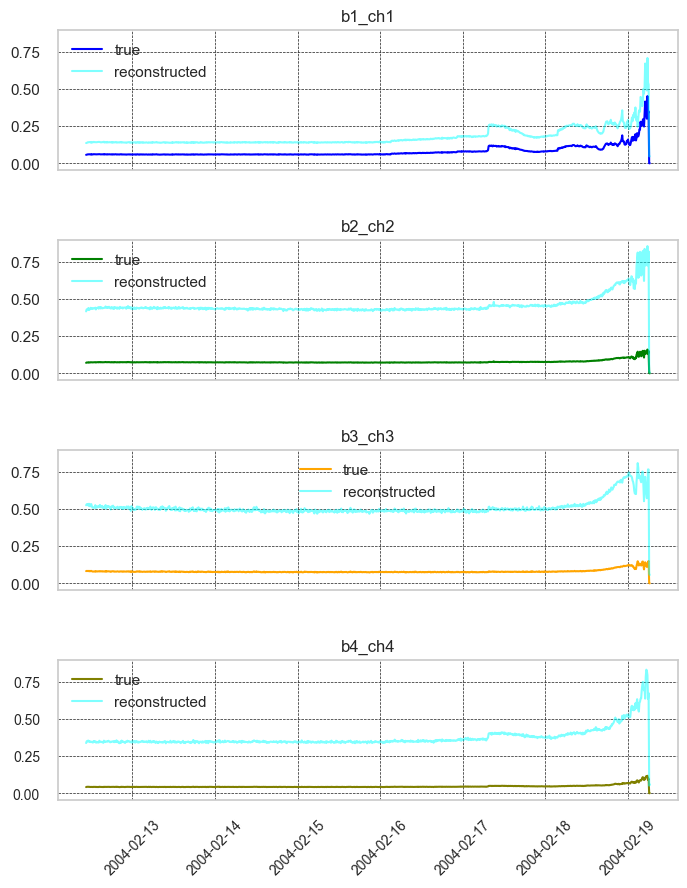

In [120]:
plot_reconstruction(avg_df2, test_preds_array, f'bilstm_test_preds_exp{exp}')

In [139]:
torch.cuda.empty_cache()